Version: 02.14.2023

# 实验 6.1：利用 Amazon Comprehend 实施主题建模

在本实验中，您将使用 Amazon Comprehend 从 [20 个新闻组] (https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups) 数据集中提取主题。

## 关于该数据集

20 个新闻组数据集是大约 20000 个新闻组文档的集合，这些文档（接近）平均分布在20个不同的新闻组中。
在对机器学习技术（如文本分类和文本聚类）的文本应用进行实验时，此集合变得十分受欢迎。在本实验中，您将了解使用神经主题模型 (NTM) 算法可以从此组文档学到哪些主题。


数据集来源：Tom Mitchell，*20 Newsgroups Data*，1999 年 9 月 9 日，由 UCI KDD Archive 分发。https://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.data.html。


## 实验步骤

要完成本实验，您需要按以下步骤操作：

1. [导入要求并创建会话变量](#1.-Importing-requirements-and-creating-session-variables)
2. [导入新闻组文件](#2.-Importing-the-newsgroup-files)
3. [检查与预处理数据](#3.-Examining-and-preprocessing-the-data)
4. [分析 Amazon Comprehend 事件输出](#4.-Analyzing-the-Amazon-Comprehend-Events-output)


## 提交作业

1.在实验室控制台中，选择 **Submit**（提交）记录您的进度，在出现提示时，选择 **Yes**（是）。

1.如果在几分钟后仍未显示结果，请返回到这些说明的顶部，并选择 **Grades**（成绩）。

     **提示**：您可以多次提交作业。您更改作业后，再次选择 **Submit**（提交）。您最后一次提交的作业将记为本实验室内容的作业。

1.要查找有关您作业的详细反馈，请选择 **Details**（详细信息），然后选择 **View Submission Report**（查看提交报告）。

## 1.导入要求和创建会话变量
([转到顶部](#Lab-6.1:-Implementing-Topic-Modeling-with-Amazon-Comprehend))

在这个部分，您将更新并安装您将在笔记本中使用的程序包。您还将创建会话变量。


In [1]:
import boto3
import uuid
# Client and session information
comprehend_client = boto3.client(service_name='comprehend')


# Constants for the S3 bucket and input data file
bucket = 'c133864a3391500l8216998t1w753251772626-labbucket-31pifhcc14df'
data_access_role_arn = 'arn:aws:iam::753251772626:role/service-role/c133864a3391500l8216998t1w-ComprehendDataAccessRole-fFX23DqzvzMS'


## 2.导入新闻组文件
([转到顶部](#Lab-6.1:-Implementing-Topic-Modeling-with-Amazon-Comprehend))

现在定义用于保存数据的文件夹。然后，清理文件夹，其中可能含有之前实验的数据。

In [2]:
import os
import shutil

data_dir = '20_newsgroups'
if os.path.exists(data_dir):  # Clean up existing data folder
    shutil.rmtree(data_dir)

新闻组文档作为单独的文件存储在 .tar 文件中。

在接下来两个单元格中，您可以解压缩数据集并提取文件列表。

In [3]:
!tar -xzf ../s3/20_newsgroups.tar.gz
!ls 20_newsgroups

alt.atheism		  rec.autos	      sci.space
comp.graphics		  rec.motorcycles     soc.religion.christian
comp.os.ms-windows.misc   rec.sport.baseball  talk.politics.guns
comp.sys.ibm.pc.hardware  rec.sport.hockey    talk.politics.mideast
comp.sys.mac.hardware	  sci.crypt	      talk.politics.misc
comp.windows.x		  sci.electronics     talk.religion.misc
misc.forsale		  sci.med


In [4]:
folders = [os.path.join(data_dir,f) for f in sorted(os.listdir(data_dir)) if os.path.isdir(os.path.join(data_dir, f))]
file_list = [os.path.join(d,f) for d in folders for f in os.listdir(d)]
print('Number of documents:', len(file_list))

Number of documents: 19997


## 3.检查与预处理数据
([转到顶部](#Lab-6.1:-Implementing-Topic-Modeling-with-Amazon-Comprehend))
    
在这个部分，您将检查数据与执行部分标准的自然语言处理 (NLP) 数据清洗任务。

In [5]:
!cat 20_newsgroups/comp.graphics/37917

Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!elroy.jpl.nasa.gov!nntp-server.caltech.edu!andrey
From: andrey@cco.caltech.edu (Andre T. Yew)
Newsgroups: comp.graphics
Subject: Re: 16 million vs 65 thousand colors
Date: 3 Apr 1993 19:51:06 GMT
Organization: California Institute of Technology, Pasadena
Lines: 28
Message-ID: <1pkpraINNck9@gap.caltech.edu>
References: <1993Mar26.210323.27802@midway.uchicago.edu> <dotzlaw-020493084300@murphy.biochem.umanitoba.ca> <d9hh.733845825@dtek.chalmers.se>
NNTP-Posting-Host: punisher.caltech.edu

d9hh@dtek.chalmers.se (Henrik Harmsen) writes:

>1-4 bits per R/G/B gives horrible machbanding visible in almost any picture.

>5 bits per R/G/B (32768, 65000 colors) gives visible machbanding

>color-gradient picture has _almost_ no machbanding. This color-resolution is 

>see some small machbanding on the smooth color-gradient picture, but all in all,
>There _ARE_ situiations where 

每个新闻组文档都可能有以下部分：
- 页眉 - 包含标准的新闻组页眉信息。它应该被移除。
- 引用文本 - 上一条消息的文本，通常有 “>” 或 “|” 前缀，并且有时以 *writes*、*wrote*、*said* 或 *says* 开头。
- 消息 - 您想要从中提取主题的消息正文。
– 页脚 – 通常以签名结尾的消息。

以下函数将移除页眉、引用文本和页脚。

In [6]:
# From sklearn.datasets.twenty_newsgroups import strip_newsgroup_header, strip_newsgroup_quoting, strip_newsgroup_footer
import re
def strip_newsgroup_header(text):
    """
    Given text in "news" format, strip the headers by removing everything
    before the first blank line.
    """
    _before, _blankline, after = text.partition('\n\n')
    return after

_QUOTE_RE = re.compile(r'(writes in|writes:|wrote:|says:|said:'
                       r'|^In article|^Quoted from|^\||^>)')


def strip_newsgroup_quoting(text):
    """
    Given text in "news" format, strip lines beginning with the quote
    characters > or |, plus lines that often introduce a quoted section
    (for example, because they contain the string 'writes:'.)
    """
    good_lines = [line for line in text.split('\n')
                  if not _QUOTE_RE.search(line)]
    return '\n'.join(good_lines)


def strip_newsgroup_footer(text):
    """
    Given text in "news" format, attempt to remove a signature block.

    As a rough heuristic, we assume that signatures are set apart by either
    a blank line or a line made of hyphens, and that it is the last such line
    in the file (disregarding blank lines at the end).
    """
    lines = text.strip().split('\n')
    for line_num in range(len(lines) - 1, -1, -1):
        line = lines[line_num]
        if line.strip().strip('-') == '':
            break

    if line_num > 0:
        return '\n'.join(lines[:line_num])
    else:
        return text

现在移除页眉、页脚和引号以清洗数据。使用刚才定义的三个函数。

In [7]:
data = []
for f in file_list:
    with open(f, 'rb') as fin:
        content = fin.read().decode('latin1')   
        content = strip_newsgroup_header(content)
        content = strip_newsgroup_quoting(content)
        content = strip_newsgroup_footer(content)
        # remove header, quoting and footer
        data.append(content)

接下来，将所有新闻组文档保存到单个文件中，每行包含一个文档。

In [8]:
with open('comprehend_input.txt','w', encoding='UTF-8') as cf:
    for line in data:
        line = line.strip()
        line = re.sub('\n',' ',line)
        line = re.sub('\r',' ',line)
        cf.write(line+'\n')

需要将数据上载到 S3 存储桶，Amazon Comprehend 才能使用数据。以下函数将数据上载到 Amazon S3。

In [9]:
s3 = boto3.resource('s3')
s3.Bucket(bucket).upload_file('comprehend_input.txt', 'comprehend/newsgroups')

In [10]:
number_of_topics = 20

input_s3_url = f"s3://{bucket}/comprehend"
input_doc_format = "ONE_DOC_PER_LINE"
input_data_config = {"S3Uri": input_s3_url, "InputFormat": input_doc_format}

output_s3_url = f"s3://{bucket}/outputfolder/"
output_data_config = {"S3Uri": output_s3_url}

job_uuid = uuid.uuid1()
job_name = f"top-job-{job_uuid}"

print(input_s3_url)

s3://c133864a3391500l8216998t1w753251772626-labbucket-31pifhcc14df/comprehend


现在开始 Amazon Comprehend 主题检测任务。

In [11]:
start_topics_detection_job_result = comprehend_client.start_topics_detection_job(NumberOfTopics=number_of_topics,
                                                                              InputDataConfig=input_data_config,
                                                                              JobName=job_name,
                                                                              OutputDataConfig=output_data_config,
                                                                              DataAccessRoleArn=data_access_role_arn
                                                                            )




获取任务状态并等待任务完成。该过程需要 25–35 分钟的时间。

In [12]:
# Get current job status
from time import sleep
job = comprehend_client.describe_topics_detection_job(JobId=start_topics_detection_job_result['JobId'])

# Loop until job is completed
waited = 0
timeout_minutes = 40
while job['TopicsDetectionJobProperties']['JobStatus'] != 'COMPLETED':
    sleep(60)
    waited += 60
    assert waited//60 < timeout_minutes, "Job timed out after %d seconds." % waited
    print('.', end='')
    job = comprehend_client.describe_topics_detection_job(JobId=start_topics_detection_job_result['JobId'])

print('Ready')

.............................Ready


任务完成后，下载结果。

In [13]:
topic_comprehend_output_file = job['TopicsDetectionJobProperties']['OutputDataConfig']['S3Uri']
print(f'output filename: {topic_comprehend_output_file}')

topics_comprehend_bucket, topics_comprehend_key = topic_comprehend_output_file.replace("s3://", "").split("/", 1)
print(topics_comprehend_key)
s3r = boto3.resource('s3')
s3r.meta.client.download_file(topics_comprehend_bucket, topics_comprehend_key, 'output.tar.gz')

output filename: s3://c133864a3391500l8216998t1w753251772626-labbucket-31pifhcc14df/outputfolder/753251772626-TOPICS-06c23b5f7b0cb37ab8cc4a0e6d444c3a/output/output.tar.gz
outputfolder/753251772626-TOPICS-06c23b5f7b0cb37ab8cc4a0e6d444c3a/output/output.tar.gz


In [14]:
# Extract the .tar file
import tarfile
tf = tarfile.open('output.tar.gz')
tf.extractall()

## 4.分析 Amazon Comprehend 事件输出
([转到顶部](#Lab-6.1:-Implementing-Topic-Modeling-with-Amazon-Comprehend))



您从 Amazon Comprehend 下载的压缩文件包含 2 个文件：

– **topic-terms.csv** 列出集合中的主题。针对每个主题，该列表包括前 10 个词语（按权重）。
– **doc-topics.csv** 列出与主题关联的文档以及与该主题相关的文档的比例。一个文档可以列在多个主题中。

将 topic-terms.csv 文件加载到 pandas DataFrame 中。

In [15]:
import pandas as pd
dftopicterms = pd.read_csv("topic-terms.csv")

查看前几行。

In [16]:
dftopicterms.head()

,topic,term,weight
0,0,people,0.031250
1,0,thing,0.011662
2,0,government,0.009719
3,0,force,0.008121
4,0,kill,0.006174


打印每个主题，以及每个主题的热门单词。

In [17]:
# Selecting rows based on condition
for t in range(0,number_of_topics):
    rslt_df = dftopicterms.loc[dftopicterms['topic'] == t]
    topic_list = rslt_df['term'].values.tolist()
    print(f'Topic {t:2} - {topic_list}')

Topic  0 - ['people', 'thing', 'government', 'force', 'kill', 'live', 'associate', 'gun', 'law', 'moral']
Topic  1 - ['find', 'source', 'information', 'stuff', 'code', 'delete', 'site', 'ftp', 'image', 'advance']
Topic  2 - ['year', 'team', 'ago', 'beat', 'win', 'player', 'play', 'game', 'league', 'season']
Topic  3 - ['work', 'bike', 'bite', 'machine', 'modem', 'suppose', 'port', 'universe', 'version', 'accurately']
Topic  4 - ['program', 'disk', 'read', 'run', 'mac', 'pc', 'book', 'write', 'speed', 'copy']
Topic  5 - ['christian', 'jesus', 'koresh', 'david', 'people', 'claim', 'church', 'christ', 'bible', 'religion']
Topic  6 - ['book', 'read', 'church', 'christian', 'randism', 'write', 'disk', 'jesus', 'article', 'bible']
Topic  7 - ['sell', 'price', 'offer', 'ship', 'include', 'pay', 'condition', 'email', 'buy', 'interest']
Topic  8 - ['post', 'day', 'article', 'read', 'delete', 'stuff', 'group', 'think', 'lot', 'reply']
Topic  9 - ['file', 'format', 'program', 'window', 'convert',

请注意，主题未被命名。这需要人工参与才能确定。

根据上一个单元格的输出中的单词，选择一个描述每个主题的单词。在下面的单元格中，将占位符文本替换为您决定用来描述每个主题的单词。

In [18]:
colnames = pd.DataFrame({'topics':['topic 0', 'topic 1', 'topic 2', 'topic 3', 'topic 4', 'topic 5', 'topic 6','topic 7','topic 8','topic 9',
       'topic 10', 'topic 11', 'topic 12', 'topic 13', 'topic 14', 'topic 15', 'topic 16','topic 17','topic 18','topic 19']})

接下来，读入 doc-topics.csv 文件。

In [19]:
dfdoctopics = pd.read_csv("doc-topics.csv")
dfdoctopics.head()

,docname,topic,proportion
0,newsgroups:3,5,1.000000
1,newsgroups:38,2,1.000000
2,newsgroups:73,6,1.000000
3,newsgroups:108,5,0.863749
4,newsgroups:108,16,0.136251


为了使可视化变得更简单，选择 5 篇文章进行绘制。

In [20]:
to_chart = dfdoctopics.loc[dfdoctopics['docname'].isin(['newsgroups:1000','newsgroups:2000','newsgroups:3000','newsgroups:4000','newsgroups:5000'])]

然后，使用  `pivot_table` 函数将 **docname** 列中的值映射到实际列。这将使创建图表变得更加容易。

In [21]:
to_chart = to_chart.pivot_table(values='proportion', index='topic', columns='docname')
to_chart.head()

docname,newsgroups:1000,newsgroups:2000,newsgroups:3000,newsgroups:4000,newsgroups:5000
topic,,,,,
3,NaN,0.120490,NaN,1.0,1.0
4,NaN,0.139562,1.0,NaN,NaN
9,NaN,0.548436,NaN,NaN,NaN
10,1.0,NaN,NaN,NaN,NaN
13,NaN,0.191513,NaN,NaN,NaN


最后，绘制属于您的新闻组文档的主题。

您将看到有些文档有单个主题，其他的则包含主题混合。如果有太多主题，您可以尝试更改主题的数量以获得更好的结果。

Matplotlib is building the font cache; this may take a moment.


Text(0.5, 0, 'Topic ID')

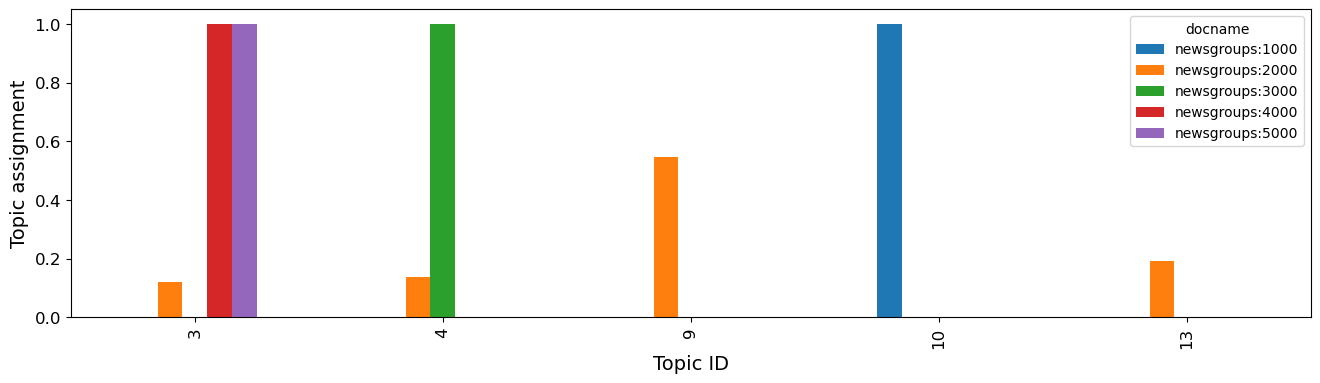

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
# df.index = colnames['topic']
to_chart.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

# 恭喜！

您已经完成了本实验室内容，现在可以按照实验室指南中的说明结束本实验室内容。

*©2023 Amazon Web Services, Inc. 或其联属公司。保留所有权利。未经 Amazon Web Services, Inc. 事先书面许可，不得复制或转载本文的部分或全部内容。禁止因商业目的复制、出借或出售本文。所有商标均为各自所有者的财产。*
